11490434/11490434 [==============================] - 1s 0us/step
Epoch 1/10
469/469 [==============================] - 179s 368ms/step - loss: 2.4747
Epoch 2/10
469/469 [==============================] - 163s 349ms/step - loss: 0.7208
Epoch 3/10
469/469 [==============================] - 165s 351ms/step - loss: 0.7146
Epoch 4/10
469/469 [==============================] - 164s 351ms/step - loss: 0.7661
Epoch 5/10
469/469 [==============================] - 159s 340ms/step - loss: 0.7490
Epoch 6/10
469/469 [==============================] - 159s 338ms/step - loss: 0.7948
Epoch 7/10
469/469 [==============================] - 159s 339ms/step - loss: 1.2161
Epoch 8/10
469/469 [==============================] - 160s 340ms/step - loss: 1.4333
Epoch 9/10
469/469 [==============================] - 159s 339ms/step - loss: 1.2392
Epoch 10/10
1/1 [==============================] - 0s 130ms/step


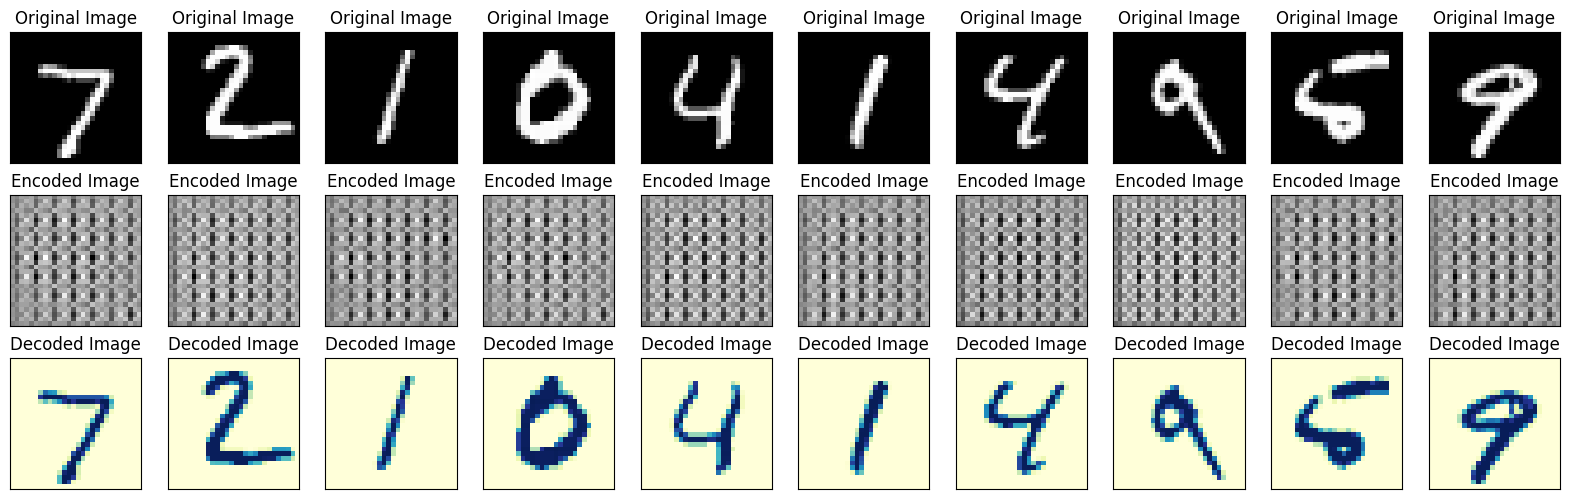

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

# Define the encoder
def build_encoder(latent_dim):
    encoder_inputs = tf.keras.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Flatten()(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    encoder = models.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")
    return encoder

# Define the decoder
def build_decoder(latent_dim):
    latent_inputs = tf.keras.Input(shape=(latent_dim,))
    x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
    x = layers.Reshape((7, 7, 64))(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
    decoder = models.Model(latent_inputs, decoder_outputs, name="decoder")
    return decoder

# Define the VAE model
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z_mean, z_log_var = self.encoder(inputs)
        z = self.sampling([z_mean, z_log_var])
        reconstructed = self.decoder(z)
        return reconstructed

    def sampling(self, args):
        z_mean, z_log_var = args
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Define the Discriminator
def build_discriminator(input_shape):
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=input_shape))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

# Define VAE-GAN model
def build_vae_gan(encoder, decoder, discriminator):
    vae_input = tf.keras.Input(shape=(28, 28, 1))
    vae = VAE(encoder, decoder)
    discriminator.trainable = False
    gan_output = discriminator(vae(vae_input))
    vae_gan = models.Model(vae_input, gan_output)
    return vae_gan

# Define loss functions
def vae_loss(z_mean, z_log_var, reconstruction, input_image):
    reconstruction_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(input_image, reconstruction))
    kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
    return reconstruction_loss + kl_loss

def discriminator_loss(real_output, fake_output):
    real_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output)
    fake_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# Build encoder, decoder, discriminator
latent_dim = 2
encoder = build_encoder(latent_dim)
decoder = build_decoder(latent_dim)
discriminator = build_discriminator((28, 28, 1))

# Build VAE-GAN model
vae_gan = build_vae_gan(encoder, decoder, discriminator)

# Compile VAE-GAN model
vae_gan.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='binary_crossentropy')

# Load dataset (for example, MNIST)
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# Train the model
vae_gan.fit(x_train, np.ones((len(x_train), 1)), epochs=10, batch_size=128)

# Generate some random latent vectors
random_latent_vectors = np.random.normal(size=(10, latent_dim))

# Decode the random latent vectors
decoded_images = decoder.predict(random_latent_vectors)

# Plot the original, decoded, and colorful images
# Plot the original, decoded, and colorful images
# Plot the original, decoded, and colorful images
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # Display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('Original Image')

    # Display decoded image
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_images[i].reshape(28, 28), cmap='gray')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('Encoded Image')

    # Display original image in color
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(x_test[i].reshape(28, 28), cmap='YlGnBu')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('Decoded Image')

plt.show()
